   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 840.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 131.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.3/322.3 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.3/39.3 MB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1

100%|██████████| 170M/170M [19:15<00:00, 148kB/s]



Starting alpha = 0.05
Alpha=0.05 client sizes: [897, 726, 196, 1874, 1307]

=== Running method: fedavg ===
 Round 1/30 | method=fedavg | drift=2.0556e+00 | test_acc=0.2251
 Round 4/30 | method=fedavg | drift=2.7648e+00 | test_acc=0.3154
 Round 7/30 | method=fedavg | drift=2.3112e+00 | test_acc=0.4037
 Round 10/30 | method=fedavg | drift=1.6551e+00 | test_acc=0.3654
 Round 13/30 | method=fedavg | drift=2.2054e+00 | test_acc=0.3626
 Round 16/30 | method=fedavg | drift=1.6317e+00 | test_acc=0.3957
 Round 19/30 | method=fedavg | drift=1.3898e+00 | test_acc=0.4514
 Round 22/30 | method=fedavg | drift=1.3223e+00 | test_acc=0.4139
 Round 25/30 | method=fedavg | drift=1.3217e+00 | test_acc=0.4631
 Round 28/30 | method=fedavg | drift=1.2689e+00 | test_acc=0.4615
 Round 30/30 | method=fedavg | drift=1.1691e+00 | test_acc=0.4431

=== Running method: fedsam ===
 Round 1/30 | method=fedsam | drift=2.1519e+00 | test_acc=0.2180
 Round 4/30 | method=fedsam | drift=2.3386e+00 | test_acc=0.3755
 Round 

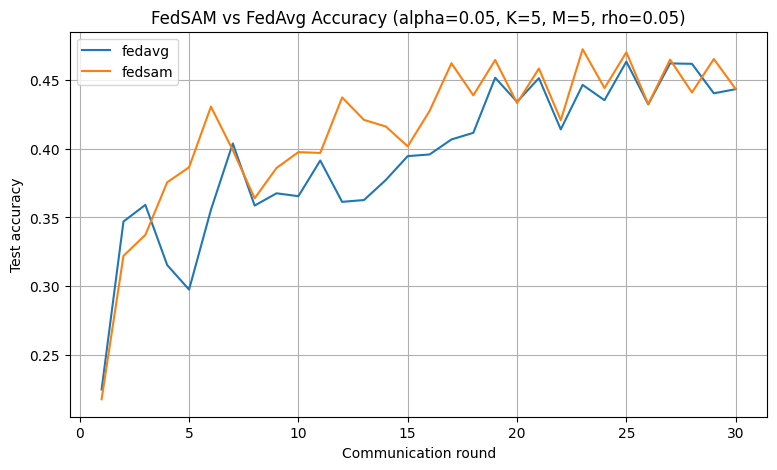

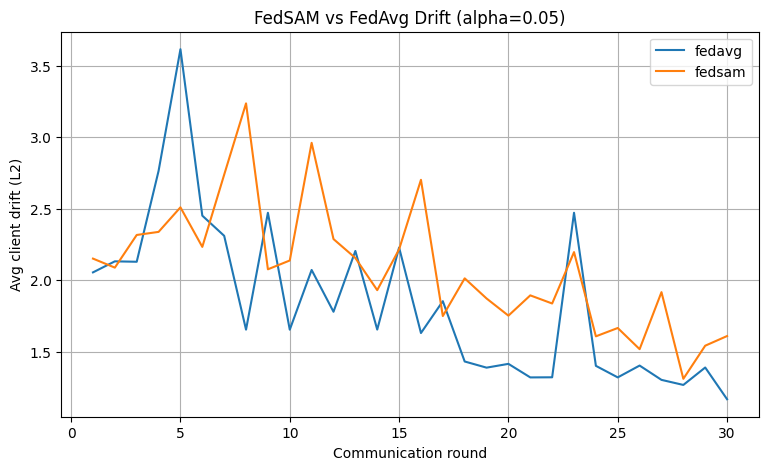

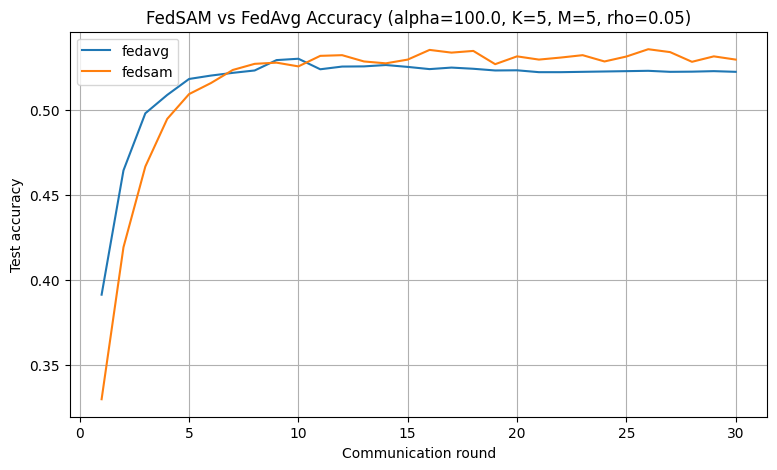

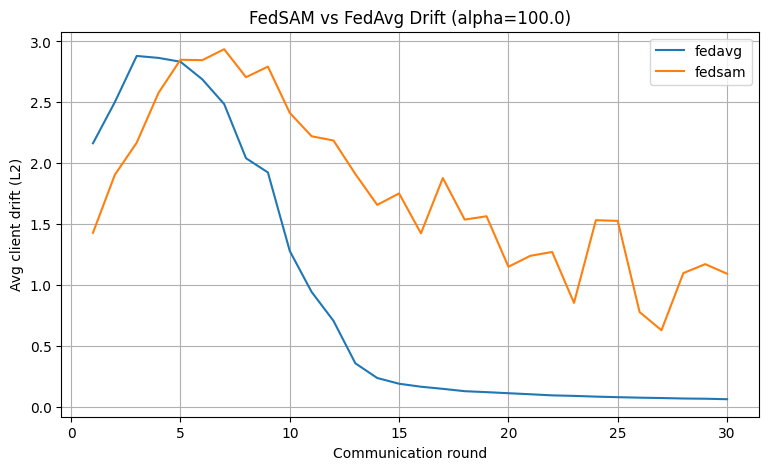


Summary (final accuracy and avg drift last 5 rounds):
alpha	method	final_acc	avg_drift_last5
0.05	fedavg	0.4431	1.3075e+00
0.05	fedsam	0.4432	1.5804e+00
100.0	fedavg	0.5222	6.7753e-02
100.0	fedsam	0.5294	9.5291e-01

Saved plots to fedsam_results/


In [ ]:
# Colab-ready: FedSAM vs FedAvg comparison
!pip -q install torch torchvision --upgrade

import torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim
import torchvision, torchvision.transforms as transforms
from torch.utils.data import Subset, DataLoader
import numpy as np, random, copy, math, os
import matplotlib.pyplot as plt
from tqdm import trange

# ===========================
# CONFIG
# ===========================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 12345
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = False

# Data / clients
M = 5                    # number of clients
total_samples = 5000     # subset of CIFAR-10 for speed
ALPHAS = [0.05, 100.0]   # non-IID and near-IID cases

# Training
K = 5                    # local epochs
ROUNDS = 30              # communication rounds
LOCAL_BS = 64
LR = 0.01
MOMENTUM = 0.9

# FedSAM specific
RHO = 0.05               # SAM perturbation radius (try 0.05, 0.02, or 0.5*LR)
METHODS = ['fedavg', 'fedsam']

SAVE_DIR = "fedsam_results"
os.makedirs(SAVE_DIR, exist_ok=True)

print("Device:", DEVICE)

# ===========================
# DATA & MODEL
# ===========================
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914,0.4822,0.4465),(0.247,0.243,0.261)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914,0.4822,0.4465),(0.247,0.243,0.261)),
])

full_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# subset for speed
all_indices = list(range(len(full_train)))
random.shuffle(all_indices)
subset_indices = all_indices[:total_samples]
subset_labels = [full_train[i][1] for i in subset_indices]

class SmallCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3,32,3,padding=1)
        self.conv2 = nn.Conv2d(32,64,3,padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(64*16*16,256)
        self.fc2 = nn.Linear(256,num_classes)
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# ===========================
# HELPERS
# ===========================
def dirichlet_partition(labels, M, alpha, seed=None):
    if seed is not None:
        np.random.seed(seed); random.seed(seed)
    labels = np.array(labels)
    client_indices = [[] for _ in range(M)]
    C = labels.max() + 1
    for c in range(C):
        idx_c = np.where(labels == c)[0].tolist()
        if len(idx_c) == 0:
            continue
        np.random.shuffle(idx_c)
        props = np.random.dirichlet([alpha]*M)
        counts = np.random.multinomial(len(idx_c), props)
        cur = 0
        for j in range(M):
            cnt = counts[j]
            if cnt>0:
                client_indices[j].extend(idx_c[cur:cur+cnt])
            cur += cnt
    client_abs = [[subset_indices[i] for i in idx_list] for idx_list in client_indices]
    return client_abs

def build_client_datasets(client_abs_indices):
    return [Subset(full_train, idxs) for idxs in client_abs_indices]

def evaluate(model, loader, device):
    model.eval()
    total=0; correct=0; loss_sum=0.0
    criterion = nn.CrossEntropyLoss(reduction='sum')
    with torch.no_grad():
        for xb,yb in loader:
            xb,yb = xb.to(device), yb.to(device)
            out = model(xb)
            loss_sum += float(criterion(out,yb).item())
            preds = out.argmax(dim=1)
            correct += int((preds==yb).sum().item())
            total += yb.size(0)
    return loss_sum/total, correct/total

def get_param_tensors(model):
    return [p.data.clone().cpu() for p in model.parameters()]

def set_param_tensors(model, tensors):
    for p,t in zip(model.parameters(), tensors):
        p.data.copy_(t.to(p.device))

def param_l2_norm_diff(paramsA, paramsB):
    s = 0.0
    for a,b in zip(paramsA, paramsB):
        diff = (a - b).view(-1)
        s += float((diff*diff).sum().cpu())
    return math.sqrt(s)

# ===========================
# LOCAL TRAIN: FedAvg (vanilla)
# ===========================
def local_train_fedavg(client_model, loader, K, optimizer, device):
    client_model.train()
    for epoch in range(K):
        for xb,yb in loader:
            xb,yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = client_model(xb)
            loss = F.cross_entropy(out,yb)
            loss.backward()
            optimizer.step()
    return get_param_tensors(client_model)

# ===========================
# LOCAL TRAIN: FedSAM (SAM per batch)
# ===========================
def local_train_fedsam(client_model, loader, K, optimizer, device, rho):
    """
    Implements SAM: for each minibatch:
      1) compute grad at w (loss1.backward())
      2) make perturbation e = rho * grad / ||grad||
         p.data.add_(e)  (with no_grad)
      3) compute grad at w_adv (loss2.backward())
      4) restore p.data.sub_(e)
      5) optimizer.step()  (will use grad from loss2)
    """
    client_model.train()
    for epoch in range(K):
        for xb,yb in loader:
            xb,yb = xb.to(device), yb.to(device)
            # first forward/backward to get gradients at current weights
            optimizer.zero_grad()
            out = client_model(xb)
            loss1 = F.cross_entropy(out, yb)
            loss1.backward()
            # compute global grad norm
            grad_norm_sq = 0.0
            for p in client_model.parameters():
                if p.grad is None:
                    continue
                grad_norm_sq += float((p.grad.detach().view(-1)**2).sum().cpu())
            grad_norm = math.sqrt(grad_norm_sq)
            if grad_norm == 0:
                # no meaningful grad -- skip SAM and just do a normal step
                optimizer.step()
                continue
            # compute perturbation (list of tensors)
            eps_list = []
            # avoid in-place issues by working with p.data
            with torch.no_grad():
                for p in client_model.parameters():
                    if p.grad is None:
                        eps_list.append(torch.zeros_like(p.data))
                        continue
                    e = (rho * p.grad.detach() / (grad_norm + 1e-12))
                    p.data.add_(e)
                    eps_list.append(e)
            # second forward/backward at perturbed weights
            optimizer.zero_grad()
            out2 = client_model(xb)
            loss2 = F.cross_entropy(out2, yb)
            loss2.backward()
            # restore original weights by removing perturbation
            with torch.no_grad():
                for p, e in zip(client_model.parameters(), eps_list):
                    p.data.sub_(e)
            # descent step using grad from perturbed point
            optimizer.step()
    return get_param_tensors(client_model)

# ===========================
# RUN experiments: FedAvg vs FedSAM
# ===========================
def run_fedsam_vs_fedavg(alpha, methods=METHODS, rounds=ROUNDS, K=K, local_bs=LOCAL_BS, lr=LR, momentum=MOMENTUM, rho=RHO, device=DEVICE, seed=SEED):
    client_abs = dirichlet_partition(np.array(subset_labels), M=M, alpha=alpha, seed=seed)
    client_sizes = [len(x) for x in client_abs]
    print(f"Alpha={alpha} client sizes: {client_sizes}")
    client_datasets = build_client_datasets(client_abs)
    client_loaders = [DataLoader(ds, batch_size=local_bs, shuffle=True) for ds in client_datasets]
    test_loader = DataLoader(test_set, batch_size=1000, shuffle=False)

    base_model = SmallCNN().to(device)
    init_state = copy.deepcopy(base_model.state_dict())

    results = {m: {'accs': [], 'drift': []} for m in methods}

    for method in methods:
        print(f"\n=== Running method: {method} ===")
        global_model = SmallCNN().to(device)
        global_model.load_state_dict(init_state)

        client_models = [SmallCNN().to(device) for _ in range(M)]
        for cm in client_models:
            cm.load_state_dict(init_state)

        for r in range(rounds):
            global_before = get_param_tensors(global_model)  # CPU snapshot
            client_params_after = []
            client_N = []

            # local training
            for i in range(M):
                client_models[i].load_state_dict(global_model.state_dict())
                optimizer = optim.SGD(client_models[i].parameters(), lr=lr, momentum=momentum)
                if len(client_loaders[i].dataset) == 0:
                    client_params_after.append(get_param_tensors(client_models[i]))
                    client_N.append(0)
                    continue
                if method == 'fedavg':
                    params_after = local_train_fedavg(client_models[i], client_loaders[i], K, optimizer, device)
                elif method == 'fedsam':
                    params_after = local_train_fedsam(client_models[i], client_loaders[i], K, optimizer, device, rho)
                else:
                    raise ValueError("Unknown method")
                client_params_after.append(params_after)
                client_N.append(len(client_loaders[i].dataset))

            # drift
            valid = [(p,s) for p,s in zip(client_params_after, client_N) if s>0]
            if len(valid) == 0:
                avg_drift = 0.0
            else:
                drift_sum = 0.0
                for p,s in valid:
                    drift_sum += param_l2_norm_diff(p, global_before)
                avg_drift = drift_sum / len(valid)
            results[method]['drift'].append(avg_drift)

            # aggregate weighted average of client params (theta_i)
            totalN = sum(client_N) if sum(client_N)>0 else 1
            # compute weighted average of full param tensors
            new_global = [torch.zeros_like(p) for p in global_before]
            for params, Ni in zip(client_params_after, client_N):
                w = (Ni/totalN) if Ni>0 else 0.0
                for idx,p in enumerate(params):
                    new_global[idx] += w * p.to(new_global[idx].device)
            set_param_tensors(global_model, new_global)

            # evaluate
            g_loss, g_acc = evaluate(global_model, test_loader, device)
            results[method]['accs'].append(g_acc)

            if (r % max(1, rounds//10) == 0) or r == rounds-1:
                print(f" Round {r+1}/{rounds} | method={method} | drift={avg_drift:.4e} | test_acc={g_acc:.4f}")

    return results

# ===========================
# Run over ALPHAS and plot
# ===========================
all_results = {}
for alpha in ALPHAS:
    print("\n" + "="*60)
    print(f"Starting alpha = {alpha}")
    res = run_fedsam_vs_fedavg(alpha, methods=METHODS, rounds=ROUNDS, K=K, local_bs=LOCAL_BS, lr=LR, momentum=MOMENTUM, rho=RHO, device=DEVICE, seed=SEED)
    all_results[alpha] = res

# Plot & save
for alpha, resdict in all_results.items():
    plt.figure(figsize=(9,5))
    for method, v in resdict.items():
        x = np.arange(1, ROUNDS+1)
        y = v['accs']
        plt.plot(x, y, label=f"{method}")
    plt.xlabel("Communication round")
    plt.ylabel("Test accuracy")
    plt.title(f"FedSAM vs FedAvg Accuracy (alpha={alpha}, K={K}, M={M}, rho={RHO})")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(SAVE_DIR, f"accuracy_alpha_{alpha}.png"))
    plt.show()

    plt.figure(figsize=(9,5))
    for method, v in resdict.items():
        x = np.arange(1, ROUNDS+1)
        y = v['drift']
        plt.plot(x, y, label=f"{method}")
    plt.xlabel("Communication round")
    plt.ylabel("Avg client drift (L2)")
    plt.title(f"FedSAM vs FedAvg Drift (alpha={alpha})")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(SAVE_DIR, f"drift_alpha_{alpha}.png"))
    plt.show()

# Summary table
print("\nSummary (final accuracy and avg drift last 5 rounds):")
print("alpha\tmethod\tfinal_acc\tavg_drift_last5")
for alpha, resdict in all_results.items():
    for method, v in resdict.items():
        final_acc = v['accs'][-1]
        avg_drift_last5 = np.mean(v['drift'][-5:]) if len(v['drift'])>=5 else np.mean(v['drift'])
        print(f"{alpha}\t{method}\t{final_acc:.4f}\t{avg_drift_last5:.4e}")

print(f"\nSaved plots to {SAVE_DIR}/")
